In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

from shapkit_nbdev.shapley_values import ShapleyValues
from shapkit_nbdev.inspector import inspector
from shapkit_nbdev.monte_carlo_shapley import MonteCarloShapley
from shapkit_nbdev.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [2]:
df = pd.read_csv("/home/sgrah/Documents/shapkit/dataset/bike/hour.csv")
df = df.drop(columns=["instant", "dteday", "yr"])
cat_features = ["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
df[cat_features] = df[cat_features].astype("str")
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [3]:
target_names = 'cnt'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
y = df[target_names].copy()


# Train a ML model

In [4]:
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)
model = CatBoostRegressor(iterations=500, depth=3,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=100)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)

# make the prediction using the resulting model
preds = model.predict(test_data)
rmse = np.sqrt(np.mean((preds - y_test)**2))
print("Test RMSE: {0:.2}".format(rmse))

0:	learn: 72.0079582	test: 68.8890183	best: 68.8890183 (0)	total: 52.7ms	remaining: 26.3s
100:	learn: 3.3868955	test: 4.0279568	best: 3.9496225 (95)	total: 389ms	remaining: 1.54s
200:	learn: 2.2990130	test: 3.3573326	best: 3.3573326 (200)	total: 635ms	remaining: 945ms
300:	learn: 1.8800424	test: 3.2616370	best: 3.2345658 (291)	total: 858ms	remaining: 567ms
400:	learn: 1.6002957	test: 3.1736670	best: 3.1580785 (393)	total: 1.16s	remaining: 285ms
499:	learn: 1.4203956	test: 3.1616702	best: 3.1245929 (474)	total: 1.5s	remaining: 0us

bestTest = 3.124592859
bestIteration = 474

Shrink model to first 475 iterations.
Test RMSE: 3.0


# Define the game

In [5]:
d = X_train.shape[1]
n = 2**d - 2
d, n

(13, 8190)

In [6]:
idx_r, idx_x = np.random.choice(np.arange(len(X_test)), size=2, replace=False)
r = X_test.iloc[idx_r,:]
x = X_test.iloc[idx_x,:]

In [7]:
print(r)
print()
print("Prediction for r: {0:.0f}".format(model.predict(r.values)))
print("Real number of bike sharing for r: {0:.0f}".format(y_test.iloc[idx_r]))

season             4
mnth              10
hr                 9
holiday            0
weekday            5
workingday         1
weathersit         1
temp             0.6
atemp         0.6061
hum              0.6
windspeed     0.0896
casual            58
registered       326
Name: 15316, dtype: object

Prediction for r: 384
Real number of bike sharing for r: 384


In [8]:
print(x)
print()
print("Prediction for x: {0:.0f}".format(model.predict(x.values)))
print("Real number of bike sharing for x: {0:.0f}".format(y_test.iloc[idx_x]))

season             4
mnth              11
hr                16
holiday            0
weekday            2
workingday         1
weathersit         3
temp             0.4
atemp         0.4091
hum             0.87
windspeed     0.2239
casual             5
registered       146
Name: 7872, dtype: object

Prediction for x: 151
Real number of bike sharing for x: 151


# Exact Shapley Values

In [9]:
# Parameters
fc = lambda x: model.predict(x)
# Computation
true_shap = ShapleyValues(x=x, fc=fc, r=r)

100%|██████████| 13/13 [00:56<00:00,  4.35s/it]


In [10]:
true_shap

season          0.000000
mnth           -0.183939
hr              0.209868
holiday         0.000000
weekday         0.519619
workingday      0.000000
weathersit     -0.116061
temp            0.245451
atemp           0.288908
hum            -0.189049
windspeed      -0.089595
casual        -53.628596
registered   -179.525021
dtype: float64

# Approximation methods

## Monte Carlo 

In [11]:
mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=100)
mc_shap

  7%|▋         | 7/100 [00:00<00:01, 59.70it/s]

new dimension 10


100%|██████████| 100/100 [00:01<00:00, 71.91it/s]


season          0.000000
mnth           -0.180603
hr              0.202141
holiday         0.000000
weekday         0.501733
workingday      0.000000
weathersit     -0.103342
temp            0.236836
atemp           0.317447
hum            -0.169246
windspeed      -0.089595
casual        -53.623452
registered   -179.560333
dtype: float64

## SGD

In [12]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, r=r, n_iter=5000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 5000/5000 [00:04<00:00, 1004.17it/s]


season         -0.572397
mnth            0.202403
hr              0.998292
holiday        -0.664087
weekday        -0.701451
workingday     -0.478794
weathersit     -0.667229
temp           -0.017127
atemp           0.073645
hum            -0.777376
windspeed       0.198334
casual        -52.363272
registered   -177.699355
dtype: float64

# Comparison with several references 

In [18]:
n_ref = 100
idx_ref = np.random.choice(X_train.shape[0], size=n_ref).flatten()
pool_ref = X_train.iloc[idx_ref]
pool_ref.head(5)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
12364,2,6,9,0,1,1,1,0.62,0.6212,0.43,0.2836,38,244
4644,3,7,10,0,0,0,1,0.74,0.6818,0.60,0.2239,127,177
5344,3,8,14,0,1,1,1,0.74,0.6818,0.55,0.0896,56,95
15406,4,10,3,0,2,1,3,0.36,0.3333,0.87,0.2836,0,3
4760,3,7,6,0,5,1,1,0.76,0.7424,0.75,0.0896,13,83


In [19]:
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d+1)), columns=["ref_pred"] + x_attributes)
for i in range(n_ref):
    r = pool_ref.iloc[i]
    ref_pred = fc(r.values)
    pool_shapley.iloc[i,0] = ref_pred
    mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=100)
    pool_shapley.iloc[i,1:] = mc_shap.values

  4%|▍         | 4/100 [00:00<00:02, 36.94it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:02, 45.59it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 52.99it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 89.08it/s]

new dimension 7


  6%|▌         | 6/100 [00:00<00:01, 58.98it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 56.83it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 73.42it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 51.87it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 68.43it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 79.87it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 59.38it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 59.71it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 63.04it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 55.58it/s]

new dimension 12


  4%|▍         | 4/100 [00:00<00:02, 36.48it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 58.18it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.24it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 57.72it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.74it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 70.34it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 77.35it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 63.59it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:01, 48.73it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 76.08it/s]

new dimension 9


  9%|▉         | 9/100 [00:00<00:01, 82.99it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 61.99it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 52.83it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.00it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.97it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 63.99it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 66.88it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.38it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 75.11it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 71.58it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 58.10it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 67.08it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 71.66it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.30it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.82it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 65.92it/s]

new dimension 12


  9%|▉         | 9/100 [00:00<00:01, 84.76it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 75.04it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 54.43it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 78.22it/s]

new dimension 9


  6%|▌         | 6/100 [00:00<00:01, 59.95it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 72.32it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.95it/s]

new dimension 12


  6%|▌         | 6/100 [00:00<00:01, 54.76it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.84it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 62.74it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 59.80it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 59.31it/s]

new dimension 10


  6%|▌         | 6/100 [00:00<00:01, 55.96it/s]

new dimension 12


 10%|█         | 10/100 [00:00<00:01, 88.81it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:02, 41.77it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.45it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 65.79it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 42.58it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 58.58it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 67.60it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 63.00it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.96it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 45.42it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 64.26it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 73.36it/s]

new dimension 10


  9%|▉         | 9/100 [00:00<00:01, 89.21it/s]

new dimension 9


  7%|▋         | 7/100 [00:00<00:01, 68.33it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 72.37it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 74.66it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:02, 46.00it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 67.91it/s]

new dimension 9


  8%|▊         | 8/100 [00:00<00:01, 69.85it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:01, 47.96it/s]

new dimension 11


  5%|▌         | 5/100 [00:00<00:02, 45.74it/s]

new dimension 11


  6%|▌         | 6/100 [00:00<00:01, 55.88it/s]

new dimension 12


  8%|▊         | 8/100 [00:00<00:01, 76.05it/s]

new dimension 10


  9%|▉         | 9/100 [00:00<00:01, 85.76it/s]

new dimension 9


  5%|▌         | 5/100 [00:00<00:02, 47.05it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 62.43it/s]

new dimension 8


  7%|▋         | 7/100 [00:00<00:01, 63.10it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 74.74it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 83.12it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 78.37it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 76.27it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.43it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 66.88it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 71.22it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 63.73it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 75.21it/s]

new dimension 10


  5%|▌         | 5/100 [00:00<00:01, 49.23it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.46it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 78.64it/s]

new dimension 10


  8%|▊         | 8/100 [00:00<00:01, 72.66it/s]

new dimension 11


  8%|▊         | 8/100 [00:00<00:01, 74.19it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 65.93it/s]

new dimension 11


  9%|▉         | 9/100 [00:00<00:01, 89.52it/s]

new dimension 8


  8%|▊         | 8/100 [00:00<00:01, 74.92it/s]

new dimension 11


  7%|▋         | 7/100 [00:00<00:01, 68.50it/s]

new dimension 10


  7%|▋         | 7/100 [00:00<00:01, 67.66it/s]

new dimension 12


  7%|▋         | 7/100 [00:00<00:01, 67.56it/s]

new dimension 11


100%|██████████| 100/100 [00:01<00:00, 69.18it/s]


In [23]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

ref_pred              188.825460
season = 4             -0.020718
mnth = 11              -0.168149
hr = 16                -0.232629
holiday = 0            -0.000749
weekday = 2             0.162369
workingday = 1          0.000000
weathersit = 3         -0.154543
temp = 0.4              0.147763
atemp = 0.4091          0.087542
hum = 0.87             -0.200309
windspeed = 0.2239     -0.037933
casual = 5            -28.241096
registered = 146       -8.668812
dtype: float64

In [24]:
np.sum(mean_pool_shap)

151.49819452844727

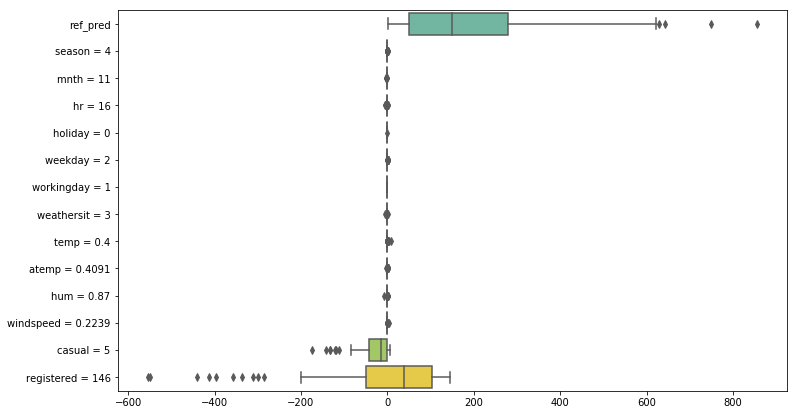

In [27]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()